Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Load Dataset

In [2]:
df = pd.read_csv("data.csv")

df.head()

,distance,duration,traffic,weather,time_of_day,demand,price
0,6.22,8.64,High,CLEAR,Morning,Medium,19.96
1,22.18,42.18,Low,Rainy,Afternoon,Medium,88.42
2,5.59,9.42,Medium,Clear,Night,High,21.02
3,6.01,8.75,Low,Clear,Evening,Low,22.97
4,18.29,24.30,High,Rainy,Night,Low,67.47


dataset overview

In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   distance     205 non-null    float64
 1   duration     205 non-null    float64
 2   traffic      205 non-null    str    
 3   weather      205 non-null    str    
 4   time_of_day  205 non-null    str    
 5   demand       205 non-null    str    
 6   price        205 non-null    float64
dtypes: float64(3), str(4)
memory usage: 11.3 KB


Check for Duplicates

In [4]:
df.duplicated().sum()

np.int64(1)

Statistical Summary (Outliers)

In [5]:
df.describe()

,distance,duration,price
count,205.000000,205.000000,205.000000
mean,16.961951,20.688146,73.767756
std,55.369169,12.181090,346.747878
min,2.130000,-50.000000,0.010000
25%,7.260000,12.120000,27.630000
50%,13.390000,19.220000,48.240000
75%,19.380000,30.250000,73.180000
max,800.000000,44.410000,5000.000000


Visualisation

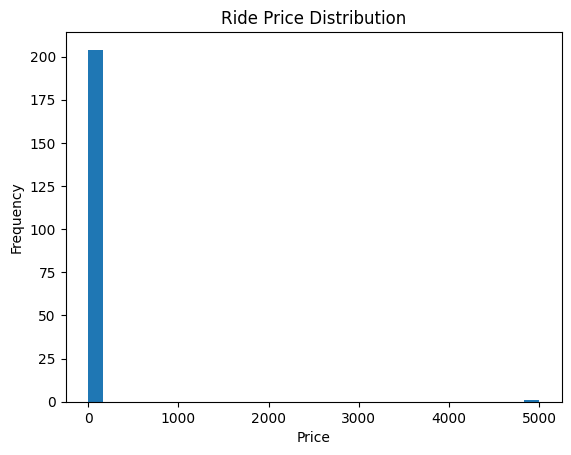

In [6]:
plt.hist(df['price'], bins=30)
plt.title("Ride Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

The histogram shows a right-skewed distribution with extreme price outliers, confirming
the need for data cleaning.

Remove duplicates

In [7]:
df = df.drop_duplicates()

Fix Categorical Inconsistencies

In [8]:
df['traffic'] = df['traffic'].str.lower().str.strip().replace({'low_': 'low'})
df['weather'] = df['weather'].str.lower().str.strip()

Handle Impossible and Extreme Value

In [9]:
# Remove negative duration values
df = df[df['duration'] > 0]

# Cap extreme values instead of deleting
df['distance'] = df['distance'].clip(upper=100)
df['price'] = df['price'].clip(upper=300)

Encode Categorical Features

In [10]:
df_encoded = pd.get_dummies(
    df,
    columns=['traffic', 'weather', 'time_of_day', 'demand'],
    drop_first=True
)

Scale Numerical Features

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_encoded[['distance', 'duration']] = scaler.fit_transform(
    df_encoded[['distance', 'duration']]
)

ModuleNotFoundError: No module named 'sklearn'

Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

ModuleNotFoundError: No module named 'sklearn'

Train Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

Predictions & Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = lr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae, rmse


Predicted vs Actual Plot

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Ride Prices")
plt.show()

Create Binary Target

In [ ]:
df_encoded['high_cost'] = (df_encoded['price'] > df_encoded['price'].median()).astype(int)

X_cls = df_encoded.drop(['price', 'high_cost'], axis=1)
y_cls = df_encoded['high_cost']

X_train, X_test, y_train, y_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)


Train Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)


Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred_cls = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_cls)
cm = confusion_matrix(y_test, y_pred_cls)

accuracy, cm


Logistic regression predicts the probability that a ride belongs to the high-cost class.
A threshold of 0.5 is used to convert probabilities into class labels.

## Model Comparison

- Linear regression predicts exact prices but is sensitive to outliers.
- Classification simplifies decision-making but loses numerical precision.
- Data quality strongly influenced both models' performance.

Distance and duration were the most influential features across models